Restricted license - for non-production use only - expires 2024-10-28
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1358 rows, 1386 columns and 8298 nonzeros
Model fingerprint: 0xefd00c80
Variable types: 63 continuous, 1323 integer (1323 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 621 rows and 360 columns
Presolve time: 0.02s
Presolved: 737 rows, 1026 columns, 9333 nonzeros
Variable types: 57 continuous, 969 integer (969 binary)

Root relaxation: objective 1.226274e+02, 120 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

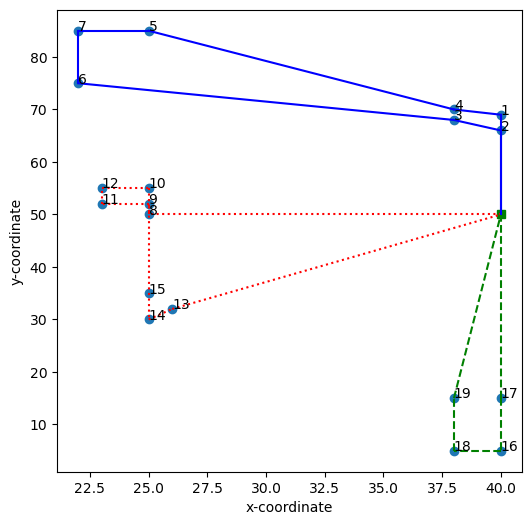

In [1]:
from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt

#============================================MODEL DATA============================================

with open("data_small.txt", "r") as f:  # Read the data file
    data = f.readlines()                       

VRP = []                                    # Create array for data related to nodes
i=0                                         # to keep track of lines in data file
for line in data:
    i=i+1
    words = line.split()
    words=[int(i) for i in words]           # Covert data from string to integer
    VRP.append(words)                       # Store node data
VRP = np.array(VRP)                         # original matrix

nodes=np.vstack((VRP, VRP[:1]))             # matrix data nodes: customers + start/end depot

N_row=nodes[:,0]                            # vector of nodes id: customers + start/end depot
n=len(N_row)                                # Number of nodes


K=3                                   # Number of vehicles
V=range(K)                                  # Set of vehicles
N=range (len (N_row))                       # Set of nodes   
C=range(1,len(N))


xc=nodes[:,1]                               # X-position of nodes
yc=nodes[:,2]                               # Y-position of nodes
a=nodes[:,3]                                # demand 
r=nodes[:,4]                                # ready time of windows
d=nodes[:,5]                                # due time of windows
s=nodes[:,6]                                # service times at customers

b=(130, 130, 130)                           # vehicle capacities
M=100000                                  # big M

# Create array for euclidian distances between nodes - c(i,j)
c=np.zeros((n,n))    
for i in N:
    for j in N:
        c[i][j]=math.sqrt((xc[j] - xc[i])**2 + (yc[j] - yc[i])**2) # Store distance between nodes
            

#========================================OPTIMIZATION MODEL========================================


## Create optimization model
m = Model('VRPmodel')

## Create Decision Variables

#arc travel - if  arc(i,j) is travelled by vehicle v it is 1, 0 otherwise
x = {}
for i in N:
    for j in N:
        for v in V:  
            x[i,j,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name="X_%s,%s,%s" %(i,j,v))
            
# arrival time of vehicle v at customer i
t = {}
for j in N:
    for v in V:
        t[j,v] = m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name="T_%s,%s" %(j,v))


## Objective - total distance traveled, i.e., total cost
obj = (quicksum(c[i,j]*x[i,j,v] for i in N for j in N for v in V))
m.setObjective(obj, GRB.MINIMIZE)


## Constraints    


# All customers visited exactly once
for i in C:
    m.addConstr(quicksum(x[i,j,v] for j in N if i != j if j!=0 for v in V )==1, 'conA[' + str(i) + ']-')
    
# Capacity constraint
for v in V:
    m.addConstr(quicksum(a[i]*x[i,j,v] for i in C for j in N if i != j if j!=0) <= b[v] , 'conE[' +  str(v) + ']-')
    
# All vehicles leave depot (once)
for v in V:
    m.addConstr(quicksum(x[0,j,v] for j in N if j!=0 )==1, 'conB[' +  str(v) + ']-')      

# Incoming and outcoming 
for h in C:
    for v in V:
         m.addConstr(quicksum(x[i,h,v] for i in N if h !=i ) == quicksum(x[h,j,v] for j in N if h!= j  ), 'conC[' + str(h) + ',' + str(v) + ']-')    

# All vehicles return to depot (once)
for v in V:
    m.addConstr(quicksum(x[i,20,v] for i in C) == 1, 'conD[' + str(v) + ']-')  


# Time window - part 1
for j in N:
    for v in V:
        m.addConstr(t[j,v] >= r[j], 'conF[' + str(j) + ',' + str(v) + ']-')   
            
# Time window- part 2
for j in N:
    for v in V:
          m.addConstr(t[j,v] <= d[j], 'conG[' + str(j) + ',' + str(v) + ']-') 
  
# Subtour elimination
for i in N:
    for j in N:
        for v in V:
            if j!=i:
                if j!=0:
                    if i!=20:
                        m.addConstr(t[i,v] + c[i,j] + s[i] - M*(1-x[i,j,v]) <= t[j,v], 'conH[' + str(i) + ',' + str(j) + ',' + str(v) + ']-') 

     

m.update()
m.write('VRPmodel.lp')
m.Params.timeLimit = 1800 #time limit so optimization will stop after 3600 seconds 
m.optimize()

# Plot the routes that are decided to be travelled 
arc_solution = m.getAttr('x', x)
#
fig= plt.figure(figsize=(6,6))
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.scatter(xc[1:n-1],yc[1:n-1])
for i in range(1,n-1):
    plt.annotate(str(i),(xc[i],yc[i]))
plt.plot(xc[0],yc[0],c='g',marker='s')
        
colors=('--g', ':r', 'b')    
    
for i in range(n):
    for j in range(n):
        for v in V:  
            if arc_solution[i, j, v] > 0.99:
                plt.plot([xc[i], xc[j]], [yc[i], yc[j]], colors[v])
  
    
  
# Display the plot
plt.show()  